
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [174]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [175]:
#from google.colab import drive
#drive.mount('/content/gdrive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [176]:
#!unzip /content/gdrive/MyDrive/upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration.zip -d /content/gdrive/MyDrive/upgrad/CNN_Assignment

In [177]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [178]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [179]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [180]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [181]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [182]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [183]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [184]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


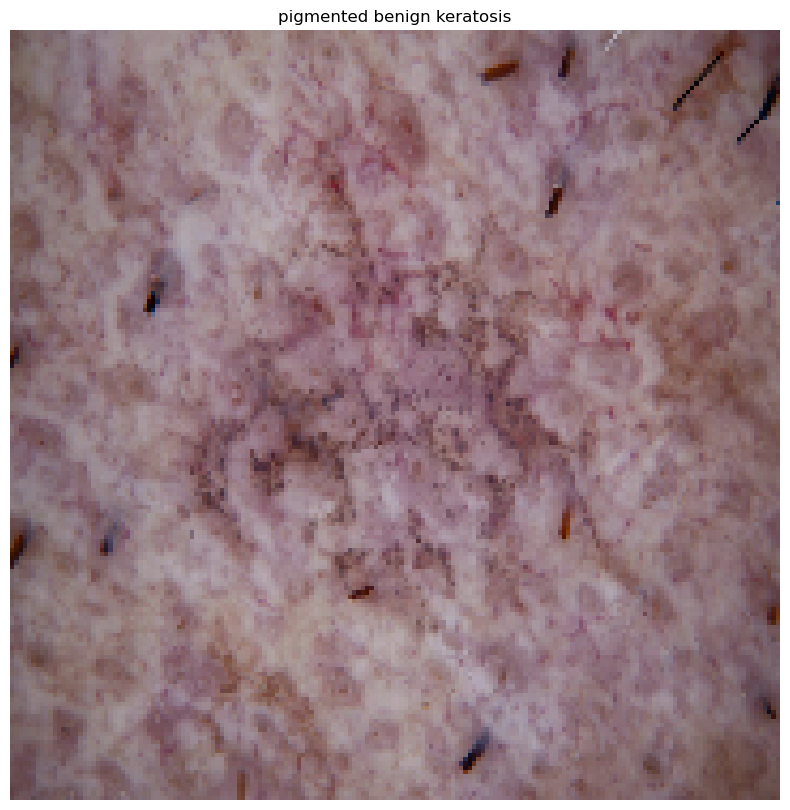

In [185]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

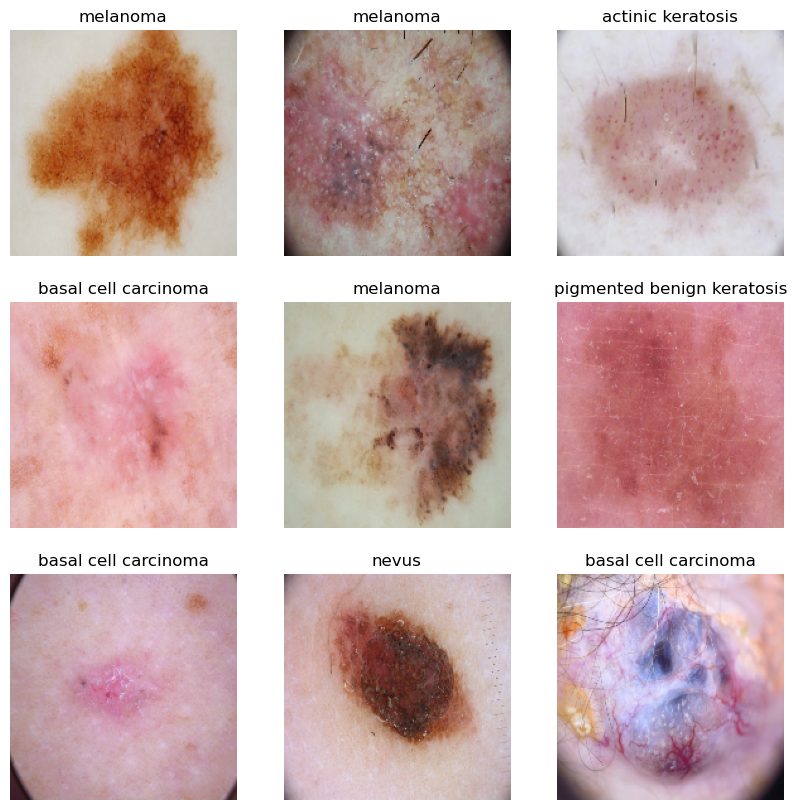

In [186]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

In [187]:
print(type(train_ds))
print(len(train_ds))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
56


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [188]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [189]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [190]:
# View the summary of all layers
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 45, 45, 64)      

In [191]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [192]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 246ms/step - loss: 2.1054 - accuracy: 0.2388 - val_loss: 1.8782 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 12s 217ms/step - loss: 1.8095 - accuracy: 0.3292 - val_loss: 1.7477 - val_accuracy: 0.3870
Epoch 3/20
56/56 [==============================] - 12s 218ms/step - loss: 1.6030 - accuracy: 0.4275 - val_loss: 1.7145 - val_accuracy: 0.3378
Epoch 4/20
56/56 [==============================] - 12s 218ms/step - loss: 1.4477 - accuracy: 0.4922 - val_loss: 1.3865 - val_accuracy: 0.5459
Epoch 5/20
56/56 [==============================] - 12s 217ms/step - loss: 1.3587 - accuracy: 0.5368 - val_loss: 1.4121 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 12s 220ms/step - loss: 1.3082 - accuracy: 0.5441 - val_loss: 1.3082 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 12s 218ms/step - loss: 1.2221 - accuracy: 0.5636 - val_loss: 1.3982 - val_accuracy: 0.5324

In [193]:
# accuracy of model each epochs
history.history['accuracy']  

[0.2388392835855484,
 0.3292410671710968,
 0.4274553656578064,
 0.4921875,
 0.5368303656578064,
 0.5440848469734192,
 0.5636160969734192,
 0.5630580186843872,
 0.6004464030265808,
 0.6088169813156128,
 0.6244419813156128,
 0.62890625,
 0.6556919813156128,
 0.6997767686843872,
 0.7165178656578064,
 0.7405133843421936,
 0.7678571343421936,
 0.7885044813156128,
 0.7979910969734192,
 0.8186383843421936]

In [194]:
# validation accuracy of model each epochs
history.history['val_accuracy']  

[0.3445190191268921,
 0.3870246112346649,
 0.3378075957298279,
 0.5458613038063049,
 0.5167785286903381,
 0.5436241626739502,
 0.5324384570121765,
 0.5458613038063049,
 0.5212528109550476,
 0.5302013158798218,
 0.5413870215415955,
 0.5234899520874023,
 0.5548098683357239,
 0.501118540763855,
 0.5436241626739502,
 0.5592840909957886,
 0.5346755981445312,
 0.5548098683357239,
 0.536912739276886,
 0.5436241626739502]

In [195]:
# loss
history.history['loss']

[2.105404853820801,
 1.8095475435256958,
 1.6030337810516357,
 1.447671890258789,
 1.35866379737854,
 1.3081825971603394,
 1.2221189737319946,
 1.2168996334075928,
 1.1210589408874512,
 1.0790190696716309,
 1.0288140773773193,
 1.0079952478408813,
 0.9519971013069153,
 0.8314170241355896,
 0.7894350290298462,
 0.7193222641944885,
 0.6495447158813477,
 0.5876426100730896,
 0.5526148676872253,
 0.49339690804481506]

### Train the model

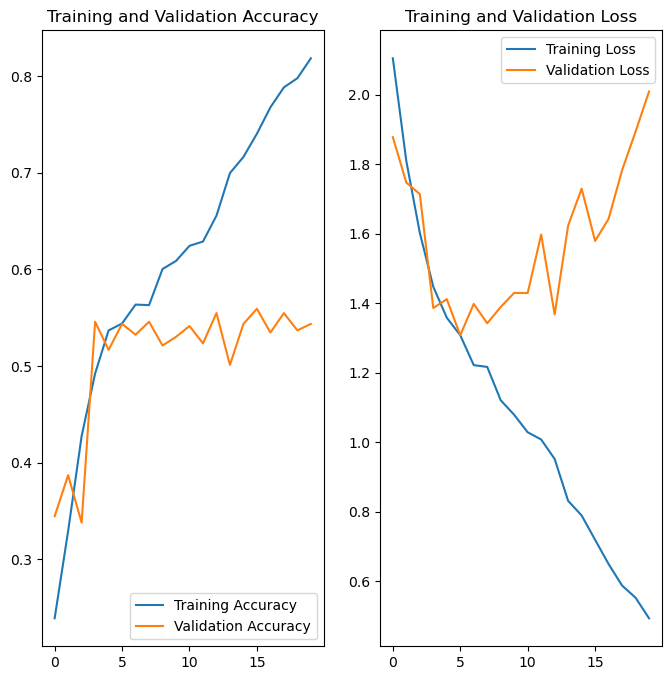

In [196]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [197]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Visualizing training results

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [198]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

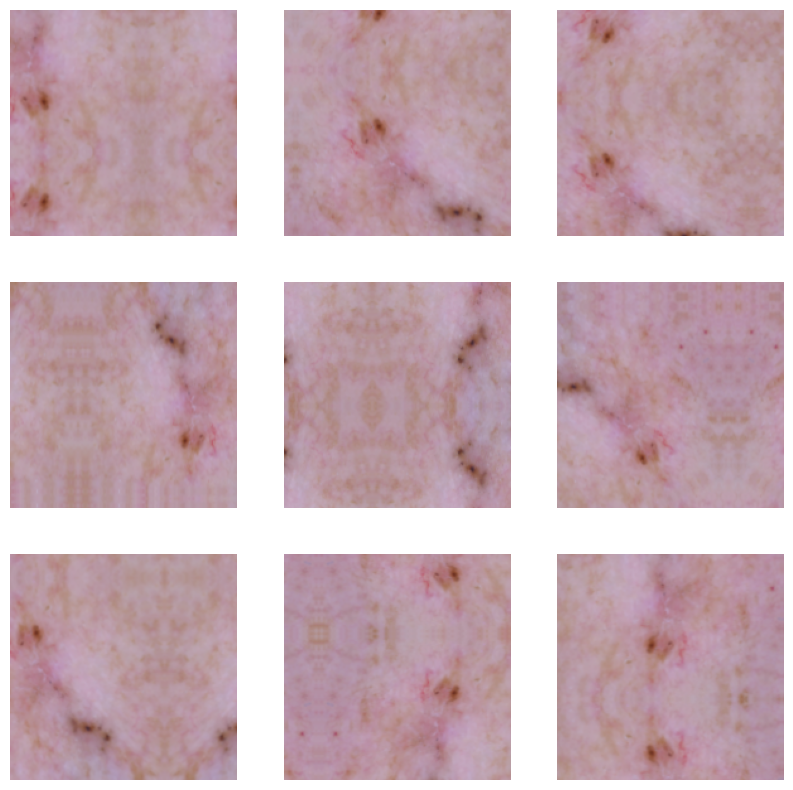

In [199]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [200]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [201]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [202]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 149s 3s/step - loss: 2.1977 - accuracy: 0.1931 - val_loss: 2.0225 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 283s 5s/step - loss: 1.9178 - accuracy: 0.2734 - val_loss: 1.7904 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 145s 3s/step - loss: 1.7909 - accuracy: 0.3365 - val_loss: 1.6712 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 195s 3s/step - loss: 1.6929 - accuracy: 0.3661 - val_loss: 1.6834 - val_accuracy: 0.3803
Epoch 5/20
56/56 [==============================] - 146s 3s/step - loss: 1.6834 - accuracy: 0.3532 - val_loss: 1.7383 - val_accuracy: 0.3400
Epoch 6/20
56/56 [==============================] - 150s 3s/step - loss: 1.6418 - accuracy: 0.3895 - val_loss: 1.5727 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 150s 3s/step - loss: 1.6020 - accuracy: 0.3929 - val_loss: 1.6148 - val_accuracy: 0.3870
Epoch 8/20
56

In [203]:
# accuracy of model each epochs
history.history['accuracy']

[0.1930803507566452,
 0.2734375,
 0.3364955484867096,
 0.3660714328289032,
 0.3532366156578064,
 0.3895089328289032,
 0.3928571343421936,
 0.4235491156578064,
 0.4162946343421936,
 0.4079241156578064,
 0.4508928656578064,
 0.4408482015132904,
 0.4559151828289032,
 0.4436383843421936,
 0.4642857015132904,
 0.4464285671710968,
 0.45703125,
 0.4626116156578064,
 0.4827008843421936,
 0.4776785671710968]

In [204]:
# validation accuracy of model each epochs
history.history['val_accuracy']  

[0.1923937350511551,
 0.35346755385398865,
 0.36465322971343994,
 0.3803131878376007,
 0.3400447368621826,
 0.4026845693588257,
 0.3870246112346649,
 0.449664443731308,
 0.4451901614665985,
 0.4384787380695343,
 0.4093959629535675,
 0.4049217104911804,
 0.42953020334243774,
 0.40715882182121277,
 0.4675615131855011,
 0.4608501195907593,
 0.501118540763855,
 0.40044742822647095,
 0.48098433017730713,
 0.5100671052932739]

In [205]:
# validation accuracy of model each epochs
history.history['loss'] 

[2.1976590156555176,
 1.917816400527954,
 1.7908916473388672,
 1.692925214767456,
 1.6834439039230347,
 1.641764521598816,
 1.6019705533981323,
 1.5886961221694946,
 1.5768684148788452,
 1.6037342548370361,
 1.5227898359298706,
 1.5656605958938599,
 1.5113022327423096,
 1.5216742753982544,
 1.481168508529663,
 1.5094003677368164,
 1.4736794233322144,
 1.459627389907837,
 1.408387541770935,
 1.4480667114257812]

### Visualizing the results

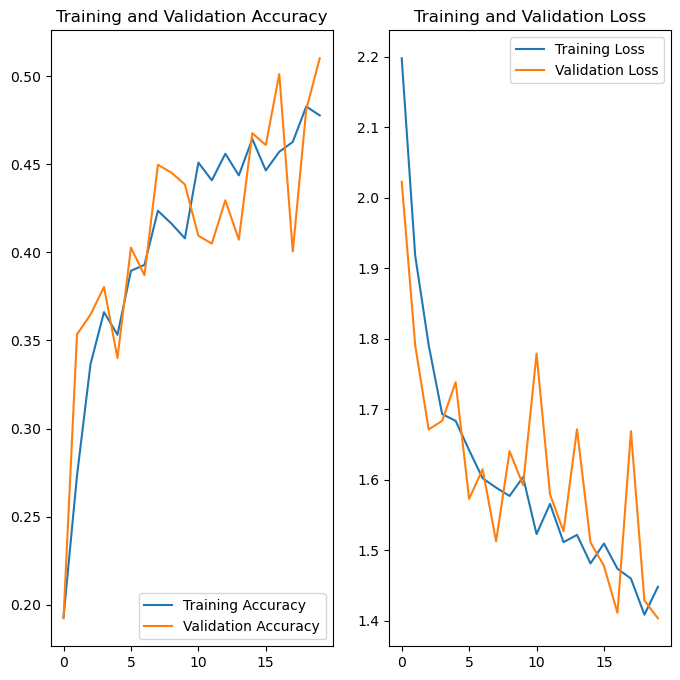

In [206]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [207]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [208]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [209]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Just your regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 102s 4s/step - loss: 2.5254 - accuracy: 0.2081 - val_loss: 2.1726 - val_accuracy: 0.1864
Epoch 2/10
23/23 [==============================] - 72s 3s/step - loss: 1.8716 - accuracy: 0.2966 - val_loss: 2.2414 - val_accuracy: 0.2373
Epoch 3/10
23/23 [==============================] - 74s 3s/step - loss: 1.6818 - accuracy: 0.3939 - val_loss: 2.2371 - val_accuracy: 0.2881
Epoch 4/10
23/23 [==============================] - 73s 3s/step - loss: 1.5243 - accuracy: 0.4542 - val_loss: 2.2357 - val_accuracy: 0.3051
Epoch 5/10
23/23 [==============================] - 64s 3s/step - loss: 1.4572 - accuracy: 0.4882 - val_loss: 1.9907 - val_accuracy: 0.3729
Epoch 6/10
23/23 [==============================] - 66s 3s/step - loss: 1.4377 - accuracy: 0.5016 - val_loss: 1.9690 - val_accuracy: 0.3644
Epoch 7/10
23/23 [==============================] - 68s 3s/step - loss: 1.3987 - accuracy: 0.5092 - val_loss: 2.0796 - val_accuracy: 0.3475
Epoch 8/10
23/23 [=

In [210]:
# accuracy of model each epochs
history.history['accuracy']

[0.20812863111495972,
 0.29656097292900085,
 0.39392584562301636,
 0.45422062277793884,
 0.48816436529159546,
 0.5015631914138794,
 0.5091558694839478,
 0.5104957818984985,
 0.5332737565040588,
 0.5163019299507141]

In [211]:
# validation accuracy of model each epochs
history.history['val_accuracy']  

[0.18644067645072937,
 0.23728813230991364,
 0.2881355881690979,
 0.3050847351551056,
 0.37288135290145874,
 0.3644067943096161,
 0.347457617521286,
 0.37288135290145874,
 0.37288135290145874,
 0.3644067943096161]

In [212]:
# validation accuracy of model each epochs
history.history['loss']  

[2.5253520011901855,
 1.871604084968567,
 1.6818252801895142,
 1.5242633819580078,
 1.457150936126709,
 1.437703013420105,
 1.3987066745758057,
 1.3881680965423584,
 1.357727289199829,
 1.368422269821167]

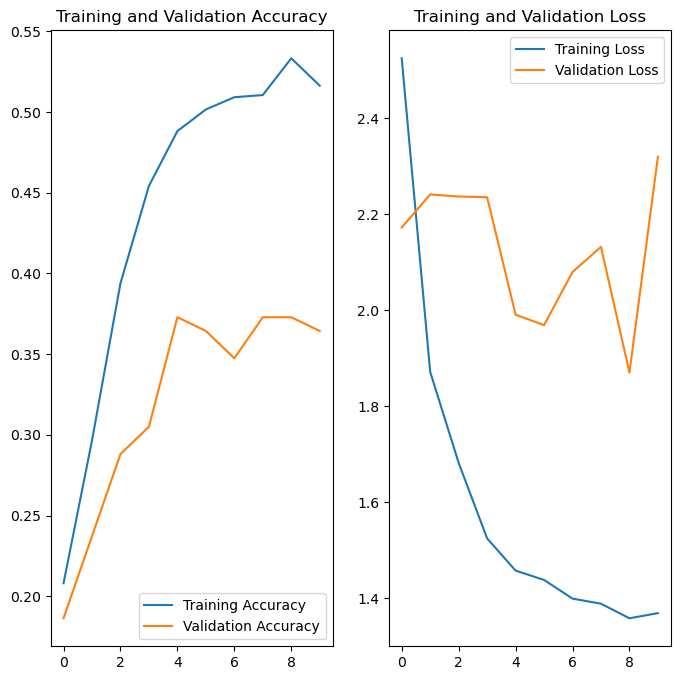

In [213]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [214]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [215]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion



-------- actinic keratosis --------
Class=0, n=114 (5.092%) 

-------- basal cell carcinoma --------
Class=1, n=376 (16.793%) 

-------- dermatofibroma --------
Class=2, n=95 (4.243%) 

-------- melanoma --------
Class=3, n=438 (19.562%) 

-------- nevus --------
Class=4, n=357 (15.945%) 

-------- pigmented benign keratosis --------
Class=5, n=462 (20.634%) 

-------- seborrheic keratosis --------
Class=6, n=77 (3.439%) 

-------- squamous cell carcinoma --------
Class=7, n=181 (8.084%) 

-------- vascular lesion --------
Class=8, n=139 (6.208%) 


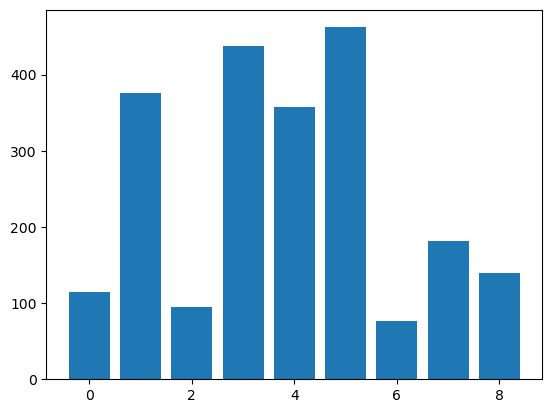

In [216]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
#print(X)
#print(y[0] )

# label encode the target variable
y1 = LabelEncoder().fit_transform(y)
#print(y1)
#rint(len(y))
# summarize distribution
counter = Counter(y1)
for k,v in counter.items():
	per = v/len(y1) * 100
	print("\n--------",class_names[k],"--------"  )
	print('Class=%d, n=%d (%.3f%%) ' % (k,v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()



27


<Figure size 1000x1000 with 0 Axes>

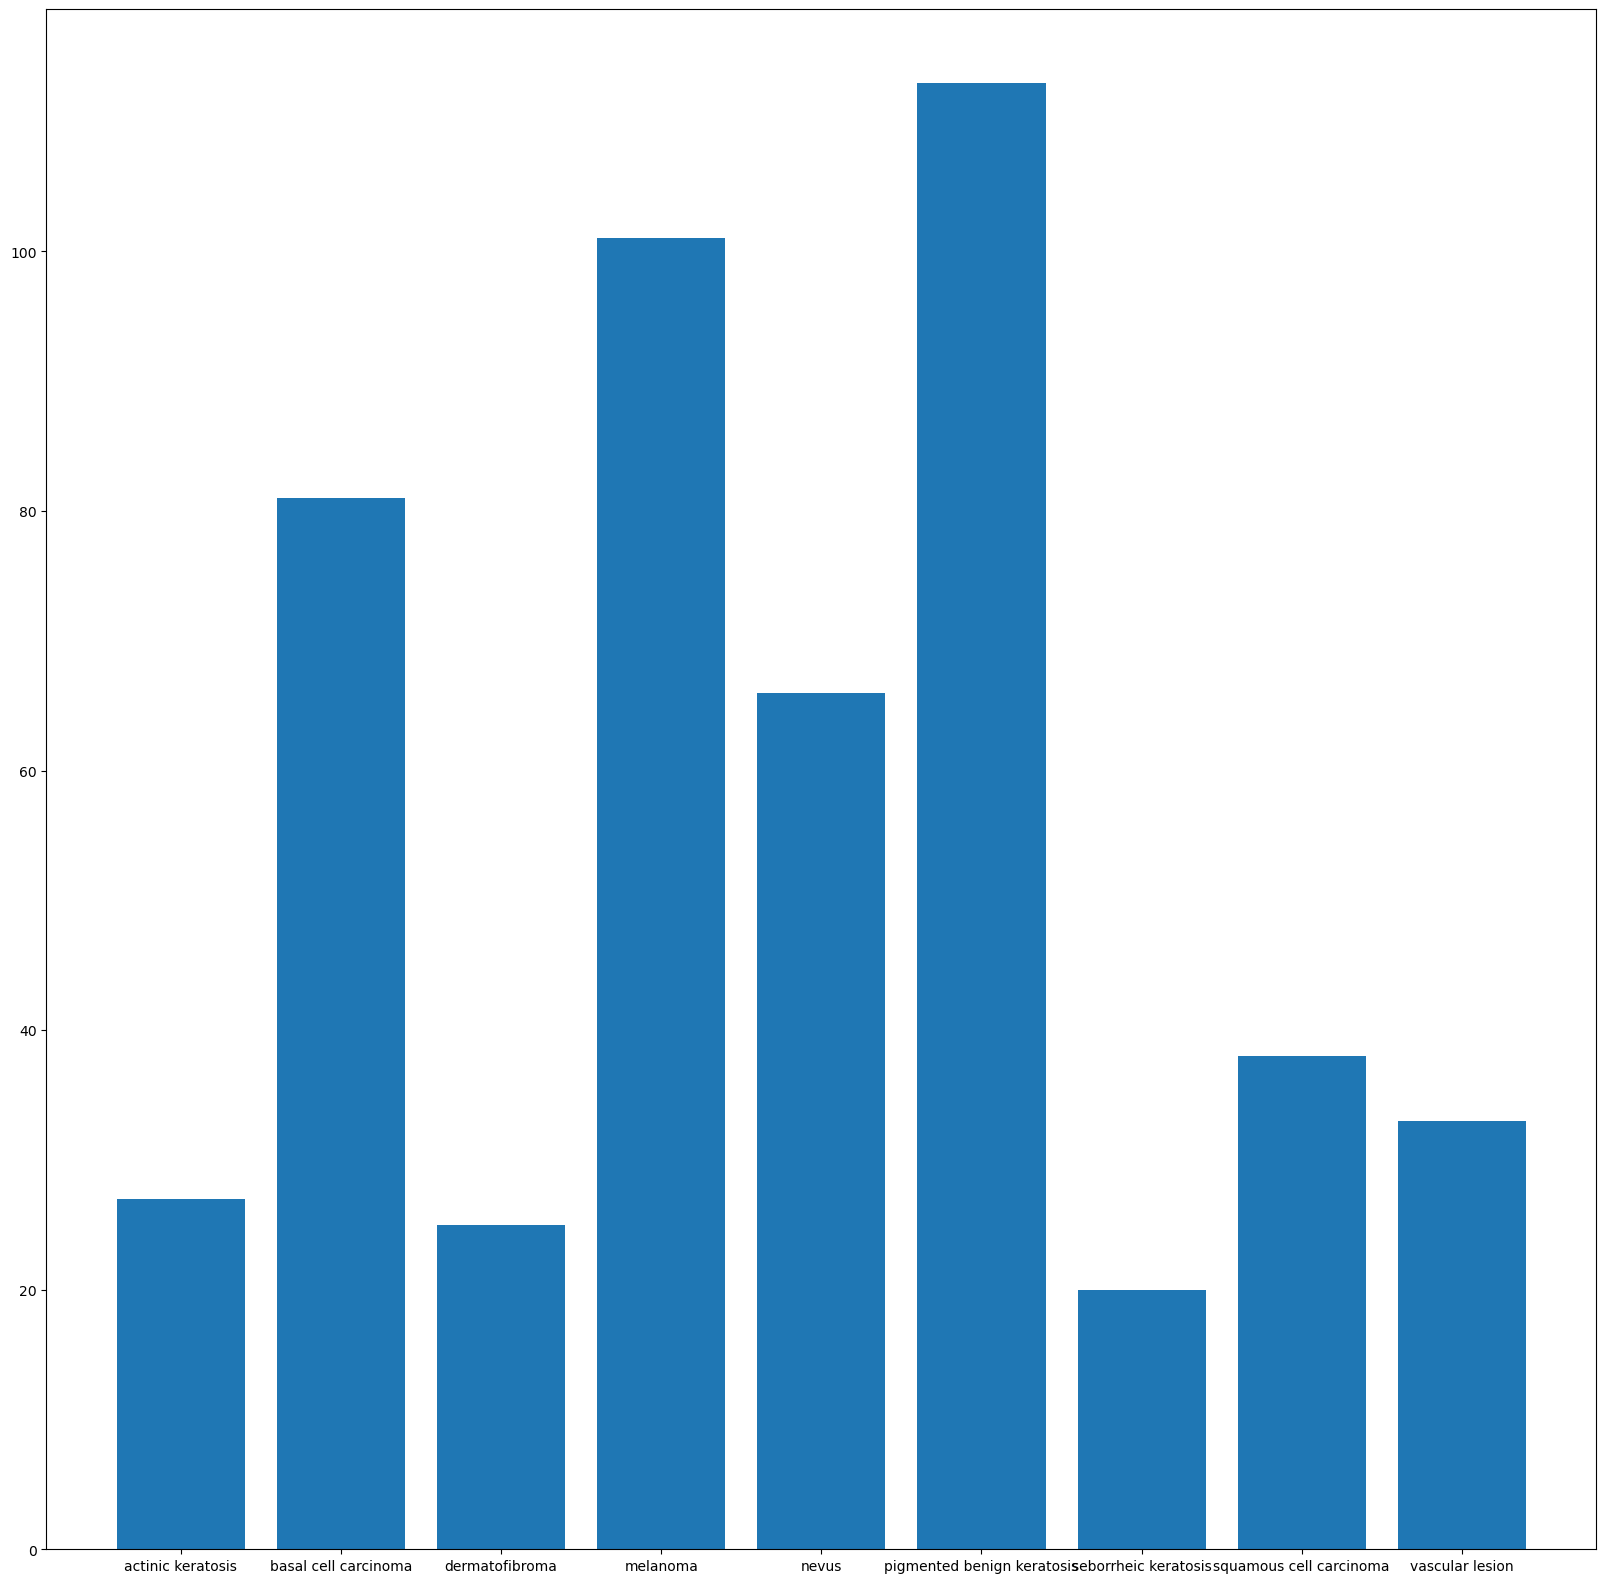

In [217]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    #print(images[i])
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

print(len(data['actinic keratosis']))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples? 
  Following class has least number of samples - Seborrheic keratosis, dermatofibroma   
   
#### - Which classes dominate the data in terms proportionate number of samples?
  Pigmented benign keratosis & melanoma dominates the data in terms proportionate number of samples 

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [218]:
!pip install Augmentor

In [219]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = r'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
p.sample(300)
p.process()


Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5C9D5A010>: 100%|██████████| 300/300 [00:01<00:00, 179.94 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B3CF023690>: 100%|██████████| 114/114 [00:00<00:00, 185.28 Samples/s]                  


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [220]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B4BB443450>: 100%|██████████| 500/500 [00:02<00:00, 231.13 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B4B90168D0>: 100%|██████████| 500/500 [00:02<00:00, 233.33 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B4BAFF3AD0>: 100%|██████████| 500/500 [00:02<00:00, 232.24 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B4B90F8B90>: 100%|██████████| 500/500 [00:11<00:00, 42.94 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x1B5C9A61790>: 100%|██████████| 500/500 [00:10<00:00, 49.50 Samples/s]   


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B4B8D3EA10>: 100%|██████████| 500/500 [00:02<00:00, 230.28 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B5CEF58ED0>: 100%|██████████| 500/500 [00:05<00:00, 99.17 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5C9A80B10>: 100%|██████████| 500/500 [00:02<00:00, 229.15 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B4BAEBB490>: 100%|██████████| 500/500 [00:02<00:00, 234.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [221]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4914


### Lets see the distribution of augmented data after adding new images to the original training data.

In [222]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0f70b6f2-a9c6-4bee-bd0e-37fe27d3ae22.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2c35a988-241b-4c64-a1da-1d76177efd0b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3e446f4c-8777-48ea-9552-fc8e1f45ff33.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4c34e36c-0aed-46f7-b65c-fde63e26d268.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4ffabd23-ab81-42aa-acdd-2ffa2edacd59.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [223]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [224]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [225]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\KALYANI\AppData\Local\Temp\ipykernel_9600\390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [226]:
new_df['Label'].value_counts()

actinic keratosis             1028
pigmented benign keratosis     962
melanoma                       938
basal cell carcinoma           876
nevus                          857
squamous cell carcinoma        681
vascular lesion                639
dermatofibroma                 595
seborrheic keratosis           577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [227]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [228]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 5723 files for training.


#### **Todo:** Create a validation dataset

In [229]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 1430 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [230]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [231]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [232]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
179/179 [==============================] - 34s 134ms/step - loss: 1.8305 - accuracy: 0.3060 - val_loss: 1.4821 - val_accuracy: 0.4315
Epoch 2/20
179/179 [==============================] - 23s 126ms/step - loss: 1.3873 - accuracy: 0.4777 - val_loss: 1.2951 - val_accuracy: 0.5014
Epoch 3/20
179/179 [==============================] - 23s 126ms/step - loss: 1.2225 - accuracy: 0.5473 - val_loss: 1.1962 - val_accuracy: 0.5497
Epoch 4/20
179/179 [==============================] - 23s 128ms/step - loss: 1.0589 - accuracy: 0.6151 - val_loss: 1.1843 - val_accuracy: 0.5601
Epoch 5/20
179/179 [==============================] - 22s 125ms/step - loss: 0.9154 - accuracy: 0.6617 - val_loss: 1.0470 - val_accuracy: 0.6455
Epoch 6/20
179/179 [==============================] - 22s 125ms/step - loss: 0.7633 - accuracy: 0.7239 - val_loss: 0.8531 - val_accuracy: 0.7035
Epoch 7/20
179/179 [==============================] - 23s 126ms/step - loss: 0.5820 - accuracy: 0.7840 - val_loss: 0.7925 - val_ac

In [233]:
# accuracy of model each epochs
history.history['accuracy'] 

[0.30595842003822327,
 0.4777214825153351,
 0.5472654104232788,
 0.6150620579719543,
 0.6617158651351929,
 0.723921000957489,
 0.7840293645858765,
 0.8174034357070923,
 0.8551459312438965,
 0.8789096474647522,
 0.8902673125267029,
 0.9126332402229309,
 0.9045954942703247,
 0.9259129762649536,
 0.9320286512374878,
 0.9065175652503967,
 0.9360475540161133,
 0.934649646282196,
 0.9428621530532837,
 0.9355233311653137]

In [234]:
# validation accuracy of model each epochs
history.history['val_accuracy']  

[0.43146851658821106,
 0.5013986229896545,
 0.5496503710746765,
 0.5601398348808289,
 0.6454545259475708,
 0.703496515750885,
 0.7475524544715881,
 0.7720279693603516,
 0.7713286876678467,
 0.7713286876678467,
 0.7958042025566101,
 0.796503484249115,
 0.7790209650993347,
 0.8209789991378784,
 0.8097901940345764,
 0.8097901940345764,
 0.8069930076599121,
 0.8027971982955933,
 0.8160839080810547,
 0.7909091114997864]

In [235]:
# validation accuracy of model each epochs
history.history['loss']  

[1.8305140733718872,
 1.3873231410980225,
 1.2225412130355835,
 1.0589098930358887,
 0.9153796434402466,
 0.7633164525032043,
 0.582012414932251,
 0.4992164373397827,
 0.4082917273044586,
 0.33257293701171875,
 0.3092682361602783,
 0.2401118129491806,
 0.2518278658390045,
 0.20057305693626404,
 0.1857730746269226,
 0.2691197991371155,
 0.17051273584365845,
 0.16531886160373688,
 0.14647790789604187,
 0.16365134716033936]

#### **Todo:**  Visualize the model results

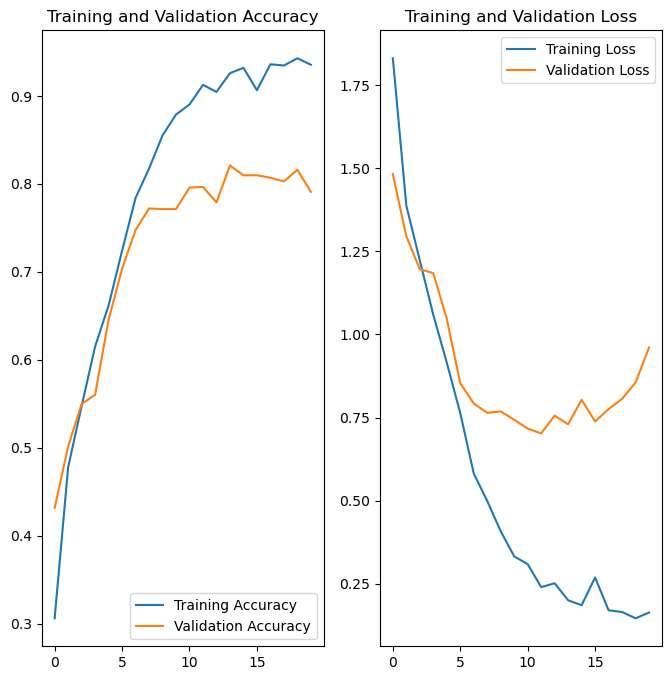

In [236]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance helped in reducing overfititng of the data and hence loss is reduced, but it reduced the Acurracy very low

Initially the training accuracy was low and loss were high 

Then we introduced dropout and then ImageDataGenerator which reduced the overfitting issue

Finally the Batch Normalization and Augumentation gave good results 